In [ ]:
import tensorflow as tf
print(tf.__version__)


In [ ]:
"""
Facial Emotion Recognition - Model Training Script
This script builds and trains a CNN model to detect 7 emotions from facial images.
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 48  # Images are 48x48 pixels
BATCH_SIZE = 64  # Process 64 images at a time
EPOCHS = 50  # Maximum training cycles
DATASET_PATH = 'dataset'  # Path to your FER2013 dataset

# Emotion labels (must match folder names)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print("=" * 60)
print("FACIAL EMOTION RECOGNITION - MODEL TRAINING")
print("=" * 60)

# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================
print("\n[STEP 1] Preparing dataset...")

# Data Augmentation for training (creates variations of images to improve learning)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to 0-1
    rotation_range=10,           # Randomly rotate images by 10 degrees
    width_shift_range=0.1,       # Shift images horizontally
    height_shift_range=0.1,      # Shift images vertically
    horizontal_flip=True,        # Flip images horizontally
    zoom_range=0.1,              # Randomly zoom
    fill_mode='nearest'          # Fill empty pixels after transformations
)

# Validation/Test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation/test data
validation_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {validation_generator.samples}")
print(f"✓ Number of classes: {len(EMOTIONS)}")

# ============================================================================
# STEP 2: BUILD THE CNN MODEL
# ============================================================================
print("\n[STEP 2] Building CNN model...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    # First Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Fourth Convolutional Block
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer (7 emotions)
    layers.Dense(len(EMOTIONS), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model built successfully!")
print(f"\n{model.summary()}")

# ============================================================================
# STEP 3: TRAIN THE MODEL
# ============================================================================
print("\n[STEP 3] Training model...")
print("This will take 30-60 minutes depending on your computer...")
print("You'll see progress for each epoch (training cycle)\n")

# Callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")

# ============================================================================
# STEP 4: EVALUATE THE MODEL
# ============================================================================
print("\n[STEP 4] Evaluating model performance...")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)

print(f"\n{'='*60}")
print(f"FINAL RESULTS:")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"{'='*60}")

# ============================================================================
# STEP 5: SAVE THE MODEL
# ============================================================================
print("\n[STEP 5] Saving model...")

model.save('face_emotionModel.h5')
print("✓ Model saved as 'face_emotionModel.h5'")

# Save training history plot
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
print("✓ Training history saved as 'training_history.png'")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE! 🎉")
print("="*60)
print("\nYou can now use 'face_emotionModel.h5' in your Flask app!")

FAST EMOTION RECOGNITION - TRAINING
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✓ Training samples: 28709
✓ Validation samples: 7178

[Building FAST model...]
✓ Model built!

Total parameters: 1,276,295

[Training - should finish in 30-60 minutes...]
Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 166s 687ms/step - accuracy: 0.2428 - loss: 2.1934 - val_accuracy: 0.2453 - val_loss: 2.1059 - learning_rate: 0.0010
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 677ms/step - accuracy: 0.3276 - loss: 1.7576 - val_accuracy: 0.2710 - val_loss: 1.9611 - learning_rate: 0.0010
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 203s 679ms/step - accuracy: 0.3912 - loss: 1.5700 - val_accuracy: 0.4521 - val_loss: 1.4164 - learning_rate: 0.0010
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 678ms/step - accuracy: 0.4285 - loss: 1.4745 - val_accuracy: 0.4668 - val_loss: 1.3648 - learning_rate: 0.0010
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 152s 676ms/step - accuracy: 0.4560 - loss: 1


FINAL RESULTS:
Test Accuracy: 60.14%

✓ Model saved as 'face_emotionModel.h5'
✓ Training complete! 🎉


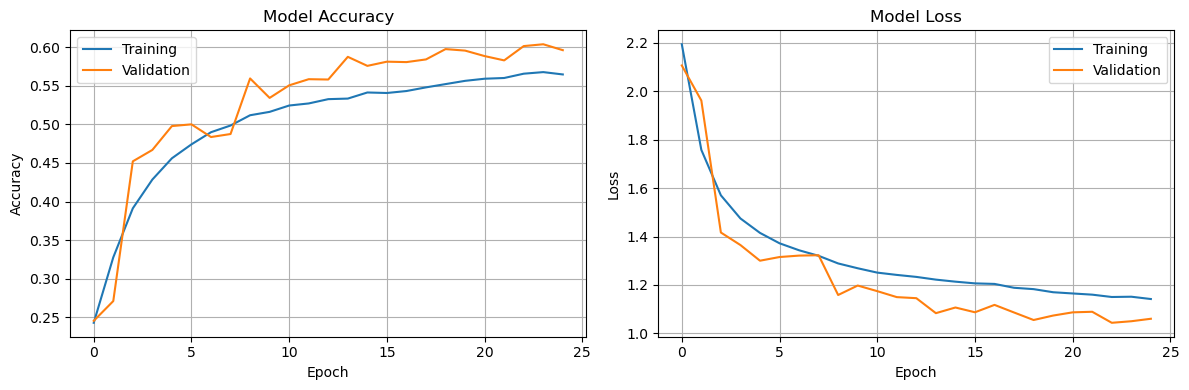

In [1]:
"""
FASTER Facial Emotion Recognition Model
Optimized for speed - will finish in 30-60 minutes
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Faster configuration
IMG_SIZE = 48
BATCH_SIZE = 128  # Larger batches = faster training
EPOCHS = 25  # Reduced from 50
DATASET_PATH = 'dataset'

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print("=" * 60)
print("FAST EMOTION RECOGNITION - TRAINING")
print("=" * 60)

# Data preparation (same as before)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {validation_generator.samples}")

# LIGHTER, FASTER MODEL
print("\n[Building FAST model...]")

model = keras.Sequential([
    # Input
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output
    layers.Dense(len(EMOTIONS), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for speed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model built!")
print(f"\nTotal parameters: {model.count_params():,}")

# Training
print("\n[Training - should finish in 30-60 minutes...]")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)

print(f"\n{'='*60}")
print(f"FINAL RESULTS:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"{'='*60}")

# Save model
model.save('face_emotionModel.h5')
print("\n✓ Model saved as 'face_emotionModel.h5'")

# Save plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
print("✓ Training complete! 🎉")

plt.show()